## Практическое задание к уроку № 6 по теме "Градиентный бустинг".

Перепишем код алгоритма с урока с ООП-виде для удобства:

In [1]:
%matplotlib inline
# Импортируем наше дерево решений из ДЗ
# к уроку № 4 для задания 3. Дерево было
# модифицировано для однообразности с
# деревом sklearn, в частности добавлен
# метод fit
import import_ipynb
from Lesson_4_mytree import DecisionTree

import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor

importing Jupyter notebook from Lesson_4_mytree.ipynb


In [2]:
def calc_mse(y, y_pred):
    return sum((y - y_pred)**2) / len(y)

In [3]:
class GradientBoosting:
    
    def __init__(self, n_trees=3, max_depth=3, eta=0.05, random_state=0, stochastic=False, tree_type='sklearn'):
        
        self.trees = []
        self.eta = eta
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.random_state = random_state
        self.stochastic = stochastic
        self.tree_type = tree_type
        
    def bias(self, y, z):
        return -2 * (z - y)
    
    def predict(self, X):
        
        return np.array([sum([self.eta * coef * alg.predict([i])[0] for alg, coef in self.trees]) for i in X])
    
    def fit(self, X, y):
        
        # Несколько строк для задания 2
        # (стохастический GB):
        np.random.seed(self.random_state)
        initial_X = X.copy()
        initial_y = y.copy()
        n = initial_X.shape[0]
        share = int(0.5 * n)
        
        for i in range(self.n_trees):
            
            # Выбор модели для задания 3:
            if self.tree_type == 'sklearn':
                tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            elif self.tree_type == 'my_tree':
                tree = DecisionTree(max_depth=self.max_depth, min_leaf=1, criterion='regression')
            
            if self.stochastic:
                idx = np.arange(n)
                np.random.shuffle(idx)
                X = initial_X[idx[:share], :]
                y = initial_y[idx[:share]]
                
            # Получим ответы на текущей композиции
            z = self.predict(X)
            
            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if not self.trees:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X, y)
            
            else:
                # алгоритмы, начиная со второго, обучаем на сдвиг
                tree.fit(X, self.bias(y, z))
            
            # весовые коэффициенты деревьев примем равными 1
            coef = 1
            
            self.trees.append((tree, coef))

#### Задание 1.  
* *Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом.*  
* *Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев).*  
* *Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).*

Возьмём данные с урока:

In [4]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

Изобразим зависимости. Ошибку будем считать только для тестовой выборки, чтобы не загромождать графики:

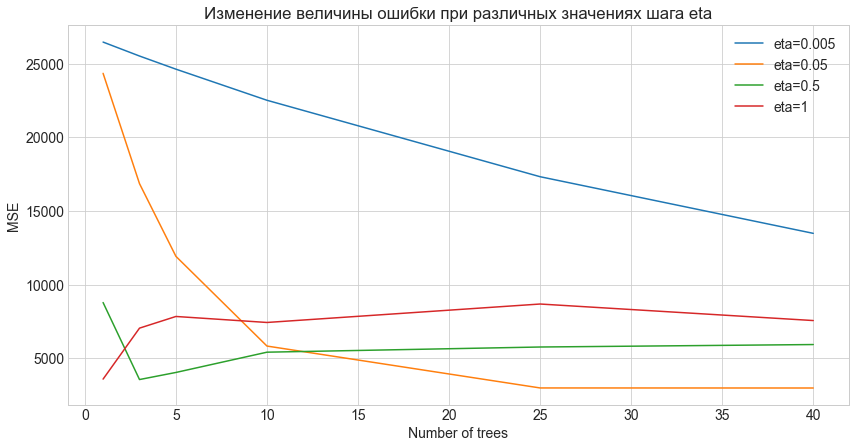

In [6]:
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14, 7))

etas = (0.005, 0.05, 0.5, 1)
n_trees = (1, 3, 5, 10, 25, 40)

for e in etas:
    mse = []
    for n in n_trees:
        model = GradientBoosting(n_trees=n, max_depth=3, eta=e, random_state=29)
        model.fit(X_train, y_train)
        mse.append(calc_mse(y_test, model.predict(X_test)))
    plt.plot(n_trees, mse, label=f'eta={e}')

plt.title('Изменение величины ошибки при различных значениях шага eta')
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.legend()
plt.show()

Сделаем выводы отдельно для каждого значения шага:  
* eta=0.005 - модель остаётся недообученной даже при 40 деревьях, шага явно недостаточно.  
* eta=0.05 - модель хорошо обучается и выходит на минимальный показатель ошибки при 25 деревьях.  
* eta=0.5 - модель показывает минимальную ошибку при 3-х деревьях, далее переобучается.
* eta=1.0 - минимальная ошибка достигнута при одном дереве, далее пошло переобучение.  

Общий вывод: оптимальное значение шага - 0.05, так как модель при этом не переобучается и достигает минимального значения ошибки при 25 деревьях.

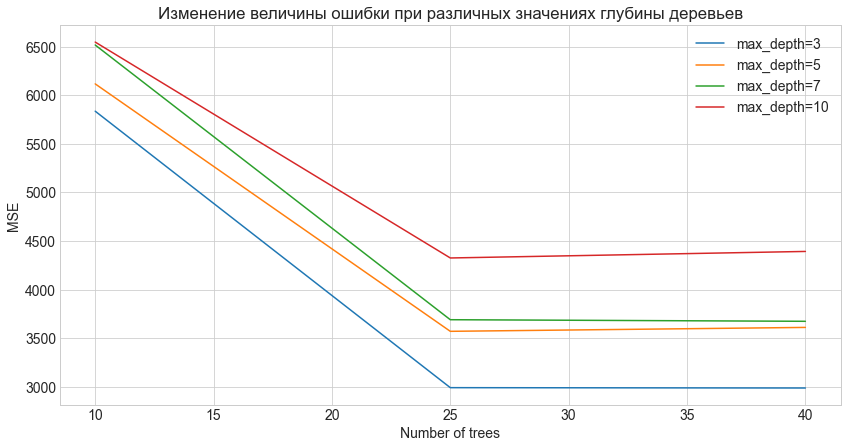

In [7]:
plt.figure(figsize=(14, 7))

depths = (3, 5, 7, 10)
n_trees = (10, 25, 40)

for depth in depths:
    mse = []
    for n in n_trees:
        model = GradientBoosting(n_trees=n, max_depth=depth, eta=0.05, random_state=29)
        model.fit(X_train, y_train)
        mse.append(calc_mse(y_test, model.predict(X_test)))
    plt.plot(n_trees, mse, label=f'max_depth={depth}')

plt.title('Изменение величины ошибки при различных значениях глубины деревьев')    
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.legend()
plt.show()

Модели с количеством деревьев менее 10 в расчёт не брались, так как график становится плохо читаемым. При малом количестве деревьев все линии сходятся ближе друг к другу и не так видна разница между ними. Нас, в любом случае, больше интересует именно этот участок, где модель имеет оптимальные параметры.  
Можно сделать вывод, что модели с максимальной глубиной деревьев 5 и 10 показали переобучение при количестве деревьев более 25, тогда как модели с глубиной деревьев 3 и 7 просто прекратили улучшать свои показатели.  
Оптимальное значение глубины деревьев равно 3, количество деревьев - 25. При этих показателях мы имеем минимальную ошибку.

По итогам данного исследования принимаем за оптимальные гиперпараметры следующие значения:  
* eta = 0.05,
* max_depth = 3,
* n_trees = 25.

Следует сделать оговорку, что интервал гиперпараметров мы рассматривали достаточно дискретно и, вполне возможно, что оптимальные значения находятся где-то между протестированными нами значениями. Также мы рассматривали зависимости гиперпараметров отдельно друг от друга, а не всевозможные их комбинации, но даже в нашем случае это было затратно для ресурсов ПК. В реальной задаче мы бы более тонко подбирали гиперпараметры.

#### Задание 2.  
*Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.  
Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.*

In [8]:
%%time

model = GradientBoosting(n_trees=50, max_depth=3, eta=0.05, random_state=29)
model.fit(X_train, y_train)

CPU times: total: 16.7 s
Wall time: 16.7 s


In [9]:
%%time

model_sgb = GradientBoosting(n_trees=50, max_depth=3, eta=0.05, random_state=29, stochastic=True)
model_sgb.fit(X_train, y_train)

CPU times: total: 8.31 s
Wall time: 8.31 s


Модель стохастического градиентного бустинга обучилась в 2 раза быстрее модели обычного GB. Сравним ошибки этих алгоритмов:

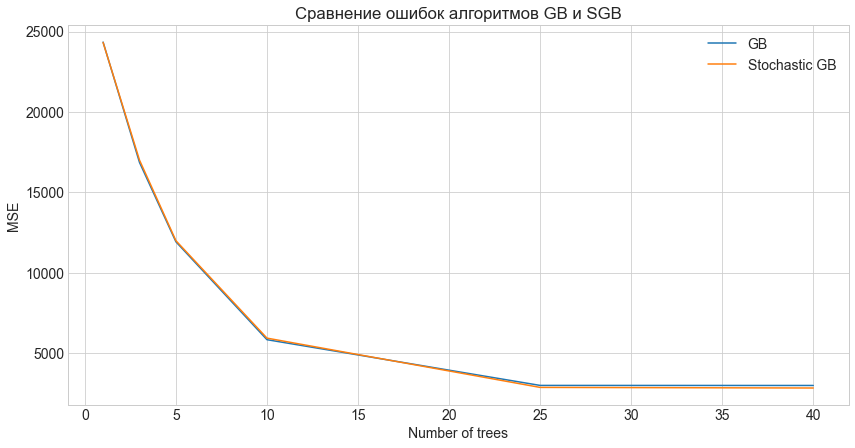

In [10]:
plt.figure(figsize=(14, 7))

n_trees = (1, 3, 5, 10, 25, 40)

mse_gb = []
mse_sgb = []

for n in n_trees:

    model_gb = GradientBoosting(n_trees=n, max_depth=3, eta=0.05, random_state=29)
    model_gb.fit(X_train, y_train)
    mse_gb.append(calc_mse(y_test, model_gb.predict(X_test)))
    
    model_sgb = GradientBoosting(n_trees=n, max_depth=3, eta=0.05, random_state=29, stochastic=True)
    model_sgb.fit(X_train, y_train)
    mse_sgb.append(calc_mse(y_test, model_sgb.predict(X_test)))
    
plt.plot(n_trees, mse_gb, label=f'GB')
plt.plot(n_trees, mse_sgb, label=f'Stochastic GB')

plt.title('Сравнение ошибок алгоритмов GB и SGB')    
plt.xlabel('Number of trees')
plt.ylabel('MSE')

plt.legend()
plt.show()

В нашем случае ошибки двух алгоритмов практически одинаковы. При числе деревьев в модели до 10 включительно чуть большую ошибку показывает модель стохастического GB. Начиная с 25 деревьев, ошибка обычного GB становится больше. При этом, скорость обучения модели стохастического градиентного бустинга в 2 раза выше, так что это хорошая альтернатива обычному GB.

#### Задание 3.  
*Модифицировать алгоритм градиентного бустинга, взяв за основу реализацию решающего дерева из ДЗ_4 (для задачи регрессии).  
Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.*

In [11]:
%%time

model_sklearn = GradientBoosting(n_trees=50, max_depth=3, eta=0.05, random_state=29)
model_sklearn.fit(X_train, y_train)

CPU times: total: 17.3 s
Wall time: 17.3 s


In [12]:
%%time

model_mytree = GradientBoosting(n_trees=50, max_depth=3, eta=0.05, random_state=29, tree_type='my_tree')
model_mytree.fit(X_train, y_train)

CPU times: total: 10.4 s
Wall time: 10.4 s


Модель с нашими деревьями обучилась в 1,5 раза быстрее.

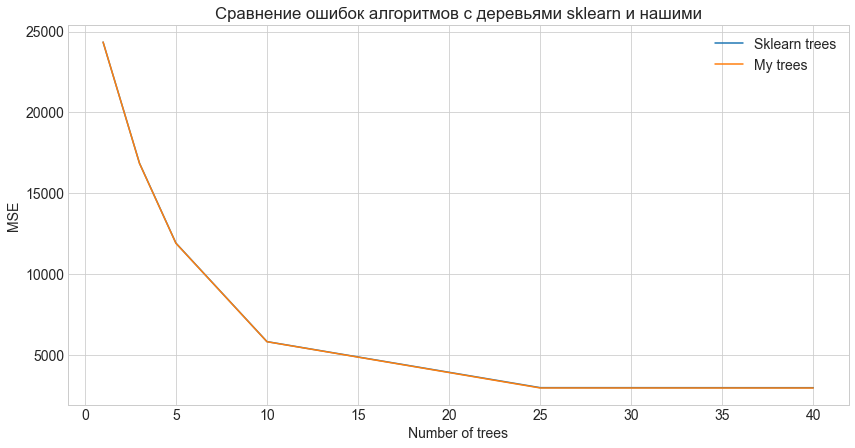

In [13]:
plt.figure(figsize=(14, 7))

n_trees = (1, 3, 5, 10, 25, 40)

mse_sklearn = []
mse_mytree = []

for n in n_trees:

    model_sklearn = GradientBoosting(n_trees=n, max_depth=3, eta=0.05, random_state=29, tree_type='sklearn')
    model_sklearn.fit(X_train, y_train)
    mse_sklearn.append(calc_mse(y_test, model_sklearn.predict(X_test)))
    
    model_mytree = GradientBoosting(n_trees=n, max_depth=3, eta=0.05, random_state=29, tree_type='my_tree')
    model_mytree.fit(X_train, y_train)
    mse_mytree.append(calc_mse(y_test, model_mytree.predict(X_test)))
    
plt.plot(n_trees, mse_sklearn, label=f'Sklearn trees')
plt.plot(n_trees, mse_mytree, label=f'My trees')

plt.title('Сравнение ошибок алгоритмов с деревьями sklearn и нашими')    
plt.xlabel('Number of trees')
plt.ylabel('MSE')

plt.legend()
plt.show()

Были протестированы два алгоритма градиентного бустинга. В одном из них базовыми алгоритмами были деревья решений из библиотеки sklearn, в другом - наши деревья решений из ДЗ к уроку № 4. Алгоритмы обучались при аналогичных критериях информативности и останова деревьев. Построен график зависимости ошибки MSE от числа деревьев в алгоритме.  
По графику мы не видим визуального отличия в значениях ошибки между двумя алгоритмами, при этом наши деревья обучаются в 1,5 раза быстрее.